In [11]:
print("Hello from kernel")


Hello from kernel


In [2]:
import pandas as pd
import numpy as np

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)

# Create simple synthetic data
np.random.seed(42)
X_syn = np.random.randn(100, 5)
y_syn = np.random.randint(0, 2, 100)

dataset_syn = pd.DataFrame(X_syn, columns=[f'feature_{i}' for i in range(5)])
dataset_syn['target'] = y_syn

print("\nSynthetic dataset shape:", dataset_syn.shape)
print("First 5 rows:")
print(dataset_syn.head())


NumPy version: 1.26.4
Pandas version: 2.3.3

Synthetic dataset shape: (100, 6)
First 5 rows:
   feature_0  feature_1  feature_2  feature_3  feature_4  target
0   0.496714  -0.138264   0.647689   1.523030  -0.234153       1
1  -0.234137   1.579213   0.767435  -0.469474   0.542560       1
2  -0.463418  -0.465730   0.241962  -1.913280  -1.724918       1
3  -0.562288  -1.012831   0.314247  -0.908024  -1.412304       0
4   1.465649  -0.225776   0.067528  -1.424748  -0.544383       1


Mean entropy (synthetic): 0.4921
First 10 entropies: [0.39554213 0.6766572  0.69314718 0.13087172 0.68257241 0.03617425
 0.36264667 0.6931357  0.63259897 0.66325893]


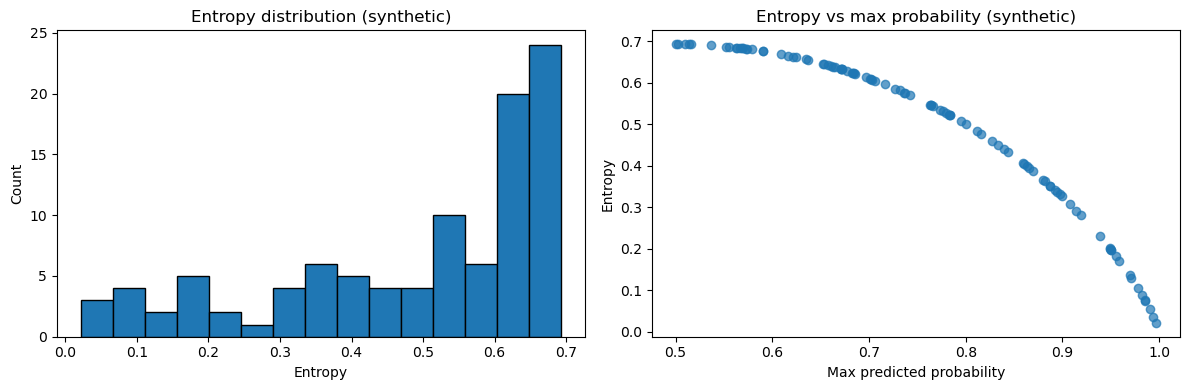

In [3]:
from scipy.stats import entropy
import matplotlib.pyplot as plt

# Simulate model prediction probabilities for 2 classes
np.random.seed(42)
probs_syn = np.random.dirichlet([1, 1], size=len(dataset_syn))  # shape (100, 2)

# Compute per-sample entropy
sample_entropies_syn = entropy(probs_syn.T)
mean_entropy_syn = sample_entropies_syn.mean()

print(f"Mean entropy (synthetic): {mean_entropy_syn:.4f}")
print("First 10 entropies:", sample_entropies_syn[:10])

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(sample_entropies_syn, bins=15, edgecolor="black")
axes[0].set_title("Entropy distribution (synthetic)")
axes[0].set_xlabel("Entropy")
axes[0].set_ylabel("Count")

max_probs_syn = probs_syn.max(axis=1)
axes[1].scatter(max_probs_syn, sample_entropies_syn, alpha=0.7)
axes[1].set_xlabel("Max predicted probability")
axes[1].set_ylabel("Entropy")
axes[1].set_title("Entropy vs max probability (synthetic)")

plt.tight_layout()
plt.show()


In [4]:
def compute_entropy_stats(probs: np.ndarray):
    """
    probs: array of shape (n_samples, n_classes) with probabilities per class.
    Returns:
        mean_entropy, sample_entropies, max_probs
    """
    from scipy.stats import entropy

    row_sums = probs.sum(axis=1, keepdims=True)
    safe_probs = probs / np.clip(row_sums, 1e-12, None)

    sample_entropies = entropy(safe_probs.T)
    mean_entropy = float(sample_entropies.mean())
    max_probs = safe_probs.max(axis=1)

    return mean_entropy, sample_entropies, max_probs

mean_entropy_syn2, sample_entropies_syn2, max_probs_syn2 = compute_entropy_stats(probs_syn)
print(f"Mean entropy (function, synthetic): {mean_entropy_syn2:.4f}")
print("First 5 entropies:", sample_entropies_syn2[:5])
print("First 5 max probs:", max_probs_syn2[:5])


Mean entropy (function, synthetic): 0.4921
First 5 entropies: [0.39554213 0.6766572  0.69314718 0.13087172 0.68257241]
First 5 max probs: [0.86512919 0.59055148 0.50004212 0.97110731 0.57258597]


Saved synthetic results to: entropy_outputs/entropy_results_synthetic.csv


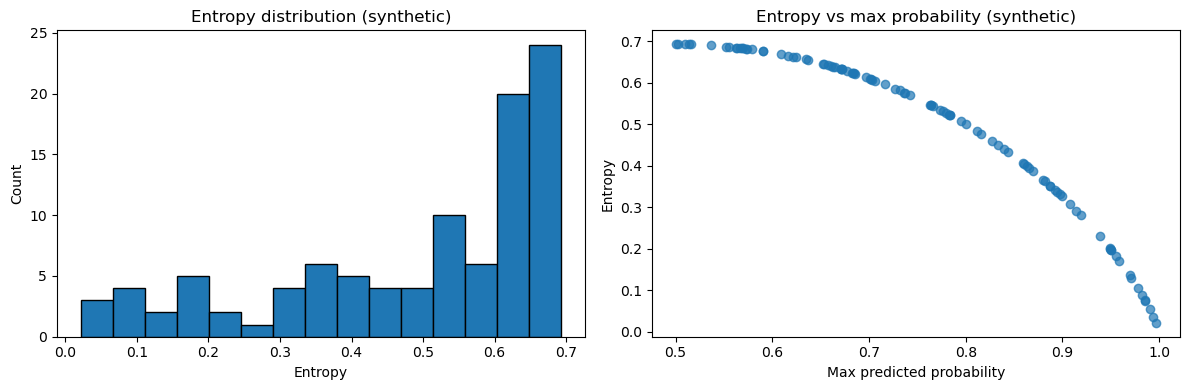

Saved synthetic figure to: entropy_outputs/entropy_plots_synthetic.png


In [5]:
import os

output_dir = "entropy_outputs"
os.makedirs(output_dir, exist_ok=True)

# Save entropy and max_prob values
results_df_syn = pd.DataFrame({
    "entropy": sample_entropies_syn2,
    "max_prob": max_probs_syn2,
})
results_path_syn = os.path.join(output_dir, "entropy_results_synthetic.csv")
results_df_syn.to_csv(results_path_syn, index=False)
print("Saved synthetic results to:", results_path_syn)

# Recreate and save the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(sample_entropies_syn2, bins=15, edgecolor="black")
axes[0].set_title("Entropy distribution (synthetic)")
axes[0].set_xlabel("Entropy")
axes[0].set_ylabel("Count")

axes[1].scatter(max_probs_syn2, sample_entropies_syn2, alpha=0.7)
axes[1].set_xlabel("Max predicted probability")
axes[1].set_ylabel("Entropy")
axes[1].set_title("Entropy vs max probability (synthetic)")

plt.tight_layout()
fig_path_syn = os.path.join(output_dir, "entropy_plots_synthetic.png")
plt.savefig(fig_path_syn, dpi=150, bbox_inches="tight")
plt.show()

print("Saved synthetic figure to:", fig_path_syn)


In [6]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load real binary classification dataset
data = load_breast_cancer(as_frame=True)
X = data.frame.drop(columns=["target"])
y = data.frame["target"]

print("Breast cancer dataset shape:", X.shape)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train a classifier
clf = RandomForestClassifier(
    n_estimators=100, max_depth=8, random_state=42, n_jobs=-1
)
clf.fit(X_train, y_train)

# Probabilities and predictions on test set
probs_real = clf.predict_proba(X_test)   # shape (n_samples, 2)
y_pred = clf.predict(X_test)

print("probs_real shape:", probs_real.shape)
print("First 5 prob vectors:\n", probs_real[:5])


Breast cancer dataset shape: (569, 30)
probs_real shape: (171, 2)
First 5 prob vectors:
 [[0.91       0.09      ]
 [0.         1.        ]
 [0.29       0.71      ]
 [1.         0.        ]
 [0.30022222 0.69977778]]


In [7]:
mean_entropy_real, entropies_real, max_probs_real = compute_entropy_stats(probs_real)

print(f"Real test mean entropy: {mean_entropy_real:.4f}")
print("First 5 entropies:", entropies_real[:5])
print("First 5 max probs:", max_probs_real[:5])


Real test mean entropy: 0.1641
First 5 entropies: [0.30253782 0.         0.60215168 0.         0.61105247]
First 5 max probs: [0.91       1.         0.71       1.         0.69977778]


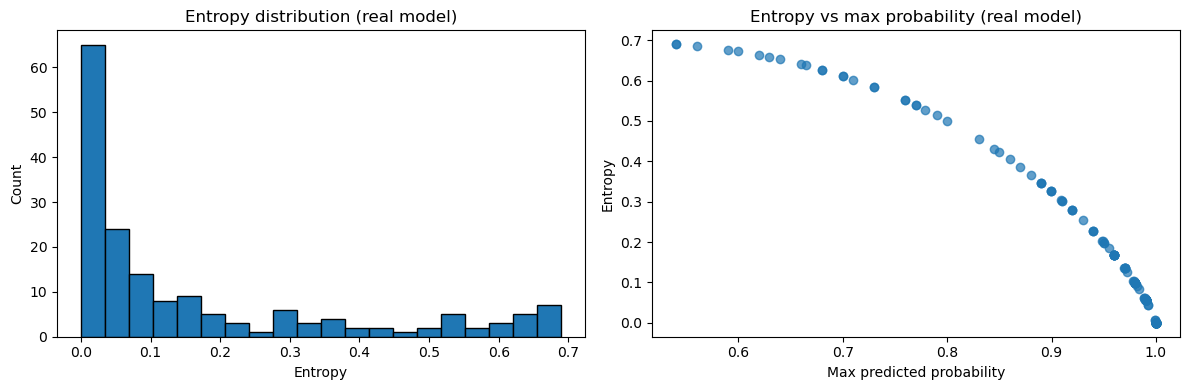

Saved real-model figure to: entropy_outputs/entropy_plots_real.png


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(entropies_real, bins=20, edgecolor="black")
axes[0].set_title("Entropy distribution (real model)")
axes[0].set_xlabel("Entropy")
axes[0].set_ylabel("Count")

axes[1].scatter(max_probs_real, entropies_real, alpha=0.7)
axes[1].set_xlabel("Max predicted probability")
axes[1].set_ylabel("Entropy")
axes[1].set_title("Entropy vs max probability (real model)")

plt.tight_layout()
fig_path_real = os.path.join(output_dir, "entropy_plots_real.png")
plt.savefig(fig_path_real, dpi=150, bbox_inches="tight")
plt.show()

print("Saved real-model figure to:", fig_path_real)


In [9]:
from evidently.report import Report
from evidently.metric_preset import ClassificationPreset
from evidently.pipeline.column_mapping import ColumnMapping


In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from evidently.report import Report
from evidently.metric_preset import ClassificationPreset
from evidently.pipeline.column_mapping import ColumnMapping

# Output dir
output_dir = "entropy_outputs"
os.makedirs(output_dir, exist_ok=True)

# Load real tabular dataset (binary classification)
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Shapes:", X_train.shape, X_test.shape)



Shapes: (398, 30) (171, 30)


In [12]:
# Real / strong model
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)
clf.fit(X_train, y_train)

# Predictions and probabilities
y_pred_real = clf.predict(X_test)
probs_real = clf.predict_proba(X_test)

acc_real = accuracy_score(y_test, y_pred_real)
print("Real model accuracy:", acc_real)

# Entropy metric using your helper
from scipy.stats import entropy

def compute_entropy_stats(probs: np.ndarray):
    row_sums = probs.sum(axis=1, keepdims=True)
    safe_probs = probs / np.clip(row_sums, 1e-12, None)
    sample_entropies = entropy(safe_probs.T)
    mean_entropy = float(sample_entropies.mean())
    max_probs = safe_probs.max(axis=1)
    return mean_entropy, sample_entropies, max_probs

mean_entropy_real, entropies_real, max_probs_real = compute_entropy_stats(probs_real)
print("Real mean entropy:", mean_entropy_real)


Real model accuracy: 0.9415204678362573
Real mean entropy: 0.16827732428390474


In [13]:
# Weak / degraded model
weak_clf = RandomForestClassifier(
    n_estimators=20,
    max_depth=2,
    random_state=42,
    n_jobs=-1,
)
weak_clf.fit(X_train, y_train)

y_pred_weak = weak_clf.predict(X_test)
probs_weak = weak_clf.predict_proba(X_test)

acc_weak = accuracy_score(y_test, y_pred_weak)
print("Weak model accuracy:", acc_weak)

mean_entropy_weak, entropies_weak, max_probs_weak = compute_entropy_stats(probs_weak)
print("Weak mean entropy:", mean_entropy_weak)


Weak model accuracy: 0.9239766081871345
Weak mean entropy: 0.2661973935499244


In [14]:
# Build combined DataFrame with your entropy metric
real_df = pd.DataFrame({
    "entropy": entropies_real,
    "max_prob": max_probs_real,
    "target": y_test.to_numpy(),
    "prediction": y_pred_real,
})
real_df["model"] = "real"

weak_df = pd.DataFrame({
    "entropy": entropies_weak,
    "max_prob": max_probs_weak,
    "target": y_test.to_numpy(),
    "prediction": y_pred_weak,
})
weak_df["model"] = "weak"

evidently_df = pd.concat([real_df, weak_df], ignore_index=True)
print(evidently_df.head())
print("Counts per model:\n", evidently_df["model"].value_counts())


    entropy  max_prob  target  prediction model
0  0.325083     0.900       0           0  real
1  0.000000     1.000       1           1  real
2  0.545248     0.765       1           1  real
3  0.031479     0.995       0           0  real
4  0.634179     0.670       0           1  real
Counts per model:
 model
real    171
weak    171
Name: count, dtype: int64


In [15]:
# Column mapping: target, prediction, plus your entropy/max_prob as numerical features
column_mapping = ColumnMapping(
    target="target",
    prediction="prediction",
    numerical_features=["entropy", "max_prob"],
    categorical_features=["model"],
)

reference_data = evidently_df[evidently_df["model"] == "real"].copy()
current_data   = evidently_df[evidently_df["model"] == "weak"].copy()

report = Report(
    metrics=[
        ClassificationPreset(),
    ]
)

report.run(
    reference_data=reference_data,
    current_data=current_data,
    column_mapping=column_mapping,
)

evidently_report_path = os.path.join(output_dir, "evidently_entropy_report.html")
report.save_html(evidently_report_path)
print("Saved Evidently report to:", evidently_report_path)


Saved Evidently report to: entropy_outputs/evidently_entropy_report.html


/tmp/ipykernel_33864/3987591740.py:7: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.


/tmp/ipykernel_33864/3987591740.py:12: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




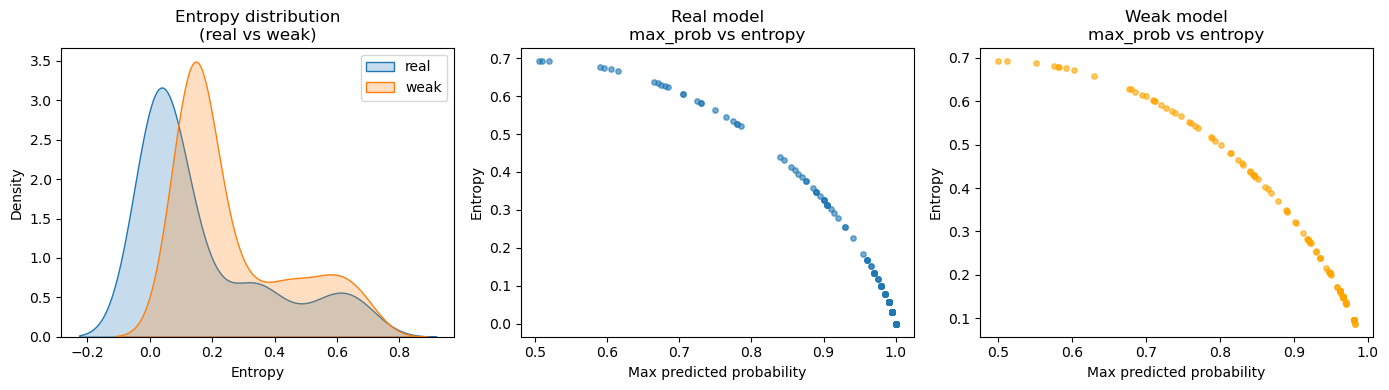

Real model accuracy: 0.9415204678362573
Weak model accuracy: 0.9239766081871345
Real mean entropy: 0.16827732428390474
Weak mean entropy: 0.2661973935499244


In [17]:
import seaborn as sns

plt.figure(figsize=(14, 4))

# 1) Entropy distributions for real vs weak
plt.subplot(1, 3, 1)
sns.kdeplot(
    evidently_df[evidently_df["model"] == "real"]["entropy"],
    label="real",
    shade=True,
)
sns.kdeplot(
    evidently_df[evidently_df["model"] == "weak"]["entropy"],
    label="weak",
    shade=True,
)
plt.xlabel("Entropy")
plt.ylabel("Density")
plt.title("Entropy distribution\n(real vs weak)")
plt.legend()

# 2) Max probability vs entropy (real)
plt.subplot(1, 3, 2)
plt.scatter(
    evidently_df[evidently_df["model"] == "real"]["max_prob"],
    evidently_df[evidently_df["model"] == "real"]["entropy"],
    alpha=0.6,
    s=15,
)
plt.xlabel("Max predicted probability")
plt.ylabel("Entropy")
plt.title("Real model\nmax_prob vs entropy")

# 3) Max probability vs entropy (weak)
plt.subplot(1, 3, 3)
plt.scatter(
    evidently_df[evidently_df["model"] == "weak"]["max_prob"],
    evidently_df[evidently_df["model"] == "weak"]["entropy"],
    alpha=0.6,
    s=15,
    color="orange",
)
plt.xlabel("Max predicted probability")
plt.ylabel("Entropy")
plt.title("Weak model\nmax_prob vs entropy")

plt.tight_layout()
plt.show()

print("Real model accuracy:", acc_real)
print("Weak model accuracy:", acc_weak)
print("Real mean entropy:", mean_entropy_real)
print("Weak mean entropy:", mean_entropy_weak)
